In [42]:
import skimage
import imageio
import tifffile
import matplotlib.pyplot as plt
import pathlib
import numpy as np
from tqdm import tqdm

from mpl_interactions import hyperslicer

In [ ]:
%matplotlib ipympl

In [3]:
def normalize_intensity(im):
    im = im.astype(np.float32)
    return (im - im.min()) / (im.max() - im.min())

In [4]:
def autoscale(im, percentile=99.9):
    """
    Scale the intensities using a percentile instead of the absolute min and max values.
    """
    vmin, vmax = np.percentile(im, [100 - percentile, percentile])
    return skimage.exposure.rescale_intensity(im, in_range=(vmin, vmax))

In [5]:
def imshow(*ims, figsize=(12, 12)):
    """
    Convenience function to visualize one or more images side-by-side.
    """
    plt.figure(figsize=figsize)
    ims = [normalize_intensity(im) for im in ims]
    plt.imshow(np.concatenate(ims, axis=1), cmap="gray")
    plt.axis("off")
    plt.show()

In [6]:
def cleanup_mask(mask):
    """
    Basic mask cleanup: remove small objects and perform a closing operation to fill in holes.
    """
    mask = skimage.morphology.isotropic_closing(mask, radius=5)
    mask = skimage.morphology.remove_small_objects(mask, min_size=100)
    return mask

In [7]:
# Find all of the tiff files in the data directory.
data_dirpath = pathlib.Path("../processed-data").absolute()
filepaths = [
    dirpath / filename
    for dirpath, _, filenames in data_dirpath.walk()
    for filename in filenames
    if filename.endswith(".tiff")
]
len(filepaths)

46

In [8]:
# Load all of the images (this is a little slow; it could be parallelized).
raw_ims = [tifffile.imread(filepath) for filepath in tqdm(filepaths)]
len(raw_ims)

100%|██████████| 46/46 [00:58<00:00,  1.28s/it]


46

## Exploratory visualization

In [9]:
# Create min-intensity projections of all FOVs and stack them into a single array.
raw_ims_proj = np.stack([im.min(axis=0) for im in raw_ims])
raw_ims_proj.shape

(46, 512, 512)

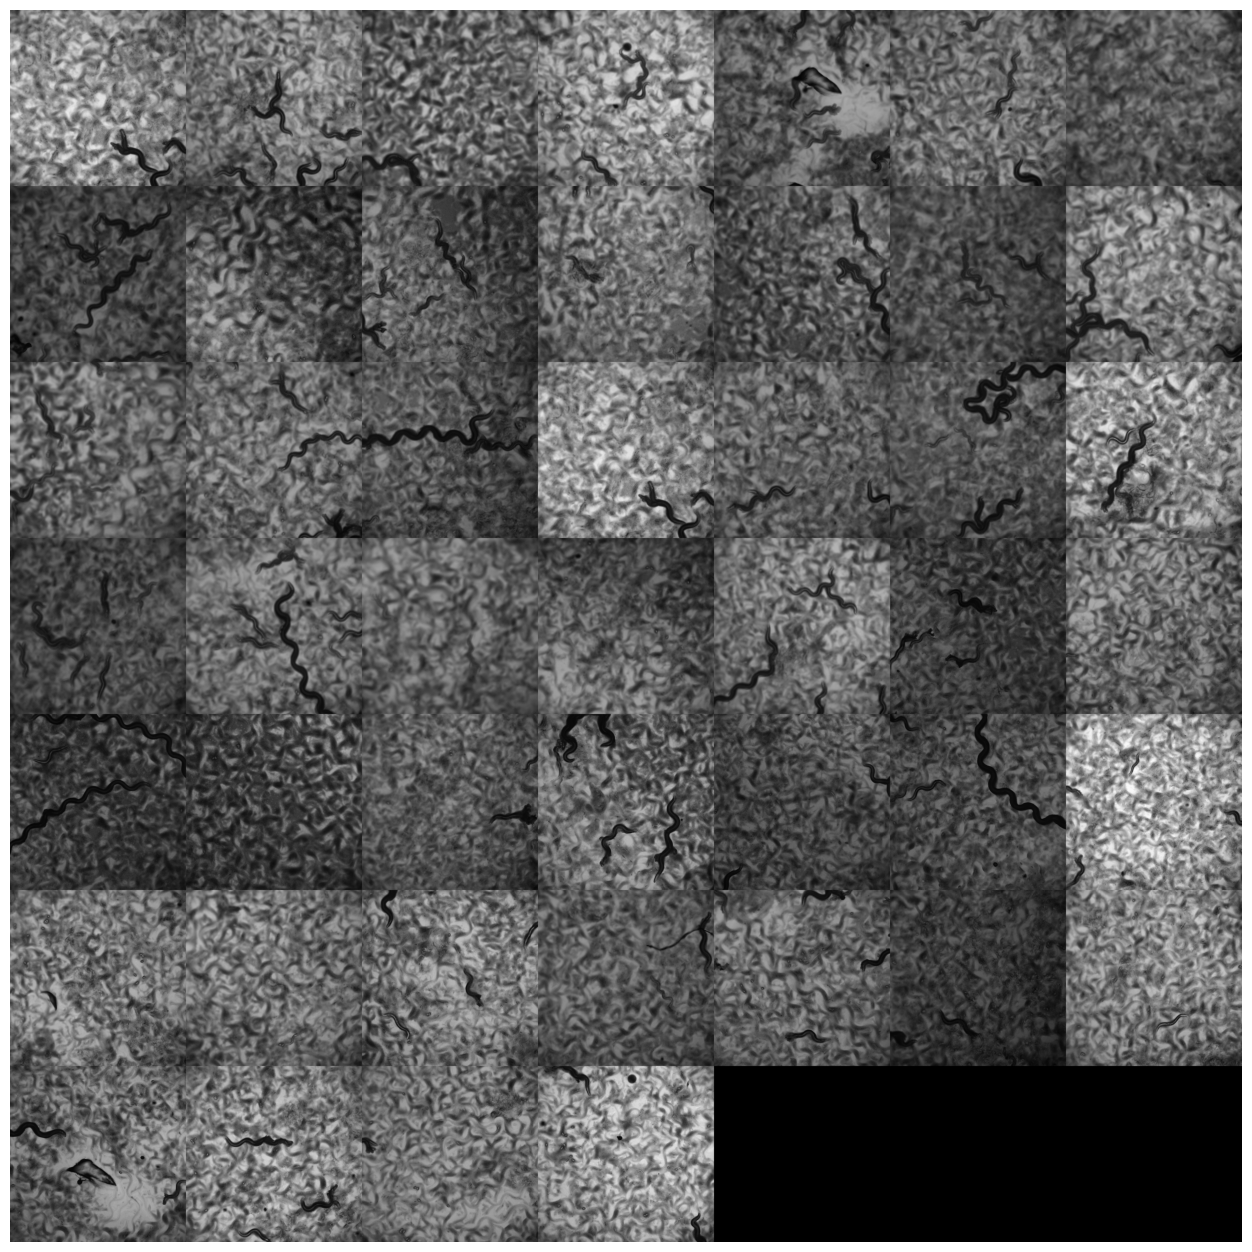

In [10]:
# Reshape the min-projections to a 2D tiled array.
n = 7
m = np.ceil(len(raw_ims_proj) / n).astype(int)

xy_size = raw_ims_proj.shape[1]

# Pad the array with zeros so that it is a multiple of n.
tiled_image = np.zeros((n * m, xy_size, xy_size), dtype=raw_ims_proj.dtype)
tiled_image[: len(raw_ims_proj)] = raw_ims_proj

# Reshape to a 2D grid of individual FOV projections.
tiled_image = (
    tiled_image.reshape(n, m, xy_size, xy_size)
    .transpose(0, 2, 1, 3)
    .reshape(n * xy_size, m * xy_size)
)

imshow(tiled_image, figsize=(16, 16))

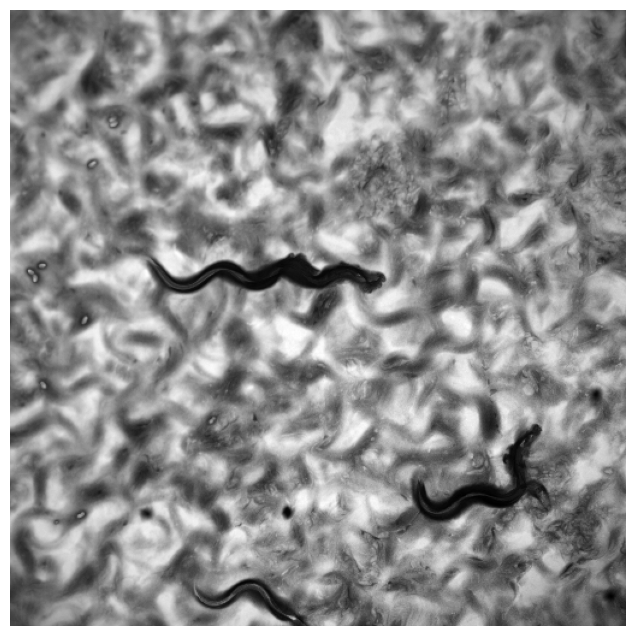

In [11]:
# Inspect single FOVs in the tiled array (I manually counted to figure out the index).
imshow(raw_ims_proj[-3, :, :], figsize=(8, 8))

In [51]:
def tile_image(im, num_timepoints=20, subsample_xy_by=2):
    """
    Tile a single 3D image (timepoints, x, y) into a 2D image (x, timepoints * y).
    """
    # Subsample to reduce the size of the concatenated image.
    subsample_timepoints_by = max(1, im.shape[0] // num_timepoints)
    im_subsampled = im[::subsample_timepoints_by, ::subsample_xy_by, ::subsample_xy_by]

    # Zero-pad the image in the x and y directions to create a black border between the frames
    # after they are concatenated.
    pad_width = 1
    size_t, size_x, size_y = im_subsampled.shape
    im_padded = np.zeros((size_t, size_x + 2 * pad_width, size_y + 2 * pad_width), dtype=im.dtype)
    im_padded[:, pad_width:-pad_width, pad_width:-pad_width] = im_subsampled

    # Concat the timepoints in the x direction (by column).
    size_t, size_x, size_y = im_padded.shape
    im_tiled = im_padded.transpose(1, 0, 2).reshape(size_x, size_t * size_y)

    return im_tiled

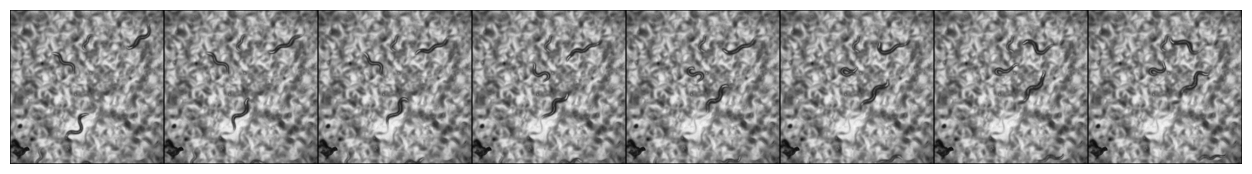

In [53]:
imshow(tile_image(raw_ims[7], num_timepoints=8), figsize=(24, 2))

In [16]:
# Hand-picked examples of in-focus and out-of-focus images.
example_inds = {
    "in-focus": (-3, 16),
    "out-of-focus": (7, 12),
    "stationary-worms": (-9, -7),
}


def get_example(name, num=None):
    """Convenience function to get an example image by name."""
    for key in example_inds.keys():
        if name in key:
            ind = example_inds[key][num if num is not None else 0]
            return raw_ims[ind].copy()

## Background subtraction

This section reimplements the background subtraction in `background_subtraction_pharaglow.py`, just as a sanity check.

In [17]:
def subtract_background(im):
    """
    Subtract the mean intensity across the first dimension (time) from each frame.
    Since most of the background is unchanging, except for where the worm crawls,
    this has the effect of removing most of the background.

    TODO: it also has the effect of removing worms that don't move, so it might be better
    to eliminate this step.
    """
    if im.ndim < 3:
        raise ValueError("Input must be a 3D array with dimensions (time, x, y).")

    im = im.astype(np.float32)
    # Use the mean instead of the median because they will be nearly the same and mean is faster,
    # and also subsample in time dimension to further speed up the computation.
    subsample_by = 5
    im -= np.mean(im[::subsample_by, :, :], axis=0)
    return im

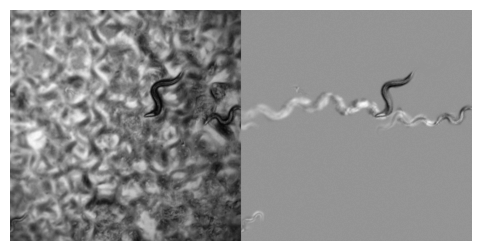

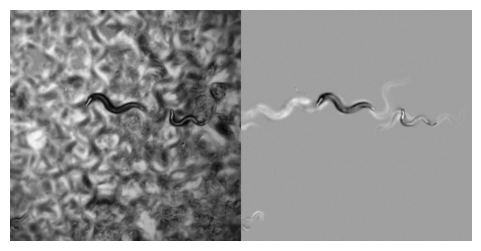

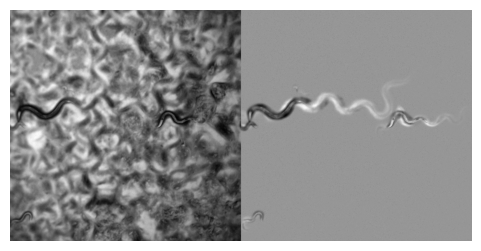

In [54]:
im_raw = get_example("in", 1)
im_bg = subtract_background(im_raw)

for ind in [0, 100, 200]:
    imshow(im_raw[ind, :, :], im_bg[ind, :, :], figsize=(6, 3))

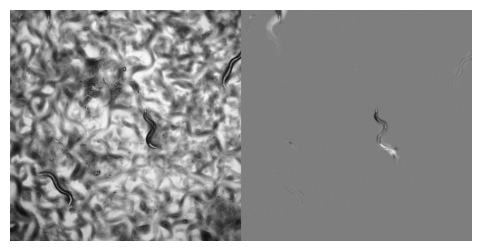

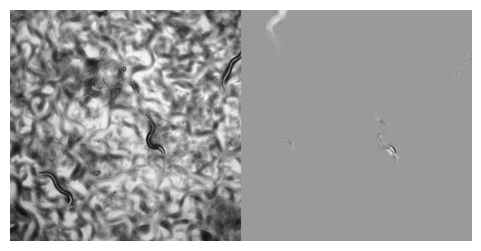

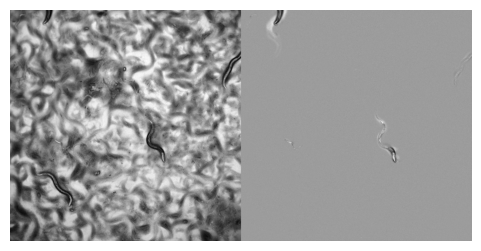

In [19]:
# View an example with stationary worms.
im_raw = get_example("stationary", 0)
im_bg = subtract_background(im_raw)

for ind in [0, 100, 200]:
    imshow(im_raw[ind, :, :], im_bg[ind, :, :], figsize=(6, 3))

### Make a crude background mask from the standard deviation across time

The logic of this is that because the true background is unchanging, we can create an approximate mask of the background by taking the standard deviation of the pixel values across time. 

This mask will be imperfect, since some worms don't move much or at all, but it is still useful as a way to estimate background intensity in later steps.

In [20]:
def make_background_mask_from_standard_deviation(im, ind=None):
    """
    Create a binary mask of the background based on the standard deviation of the image.
    """
    if im.ndim < 3:
        raise ValueError("Input image must have at least 3 dimensions.")

    subsample_by = 3
    window = 30
    if ind is not None:
        im = im[max(0, ind - window) : min(ind + window, len(im)), :, :]
        subsample_by = 1

    std = im[::subsample_by, :, :].std(axis=0)
    thresh = skimage.filters.threshold_otsu(std)
    mask = std > thresh
    return std, mask

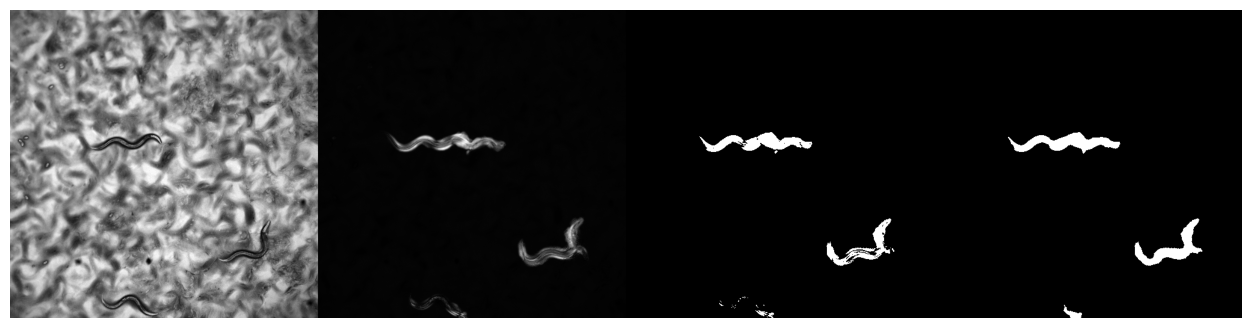

In [21]:
im = get_example("in", 0)

ind = 100
std, mask = make_background_mask_from_standard_deviation(im, ind=None)
imshow(im[ind, :, :], std, mask, cleanup_mask(mask), figsize=(16, 4))

## Generating a frame-wise background mask

This means generating a binary image where the background is white and the foreground is black. The white regions should correspond to the worms, and the black regions should correspond to the background.

### Generating a frame-wise background mask *after* background subtraction

This appears to be pretty easy: the background-subtracted frames are so clean that a simple thresholding operation is enough to generate a relatively clean frame-wise background mask.

But it has some problems: stationary worms are lost, and the "ghosting" around mobile worms degrades the quality of the background mask.

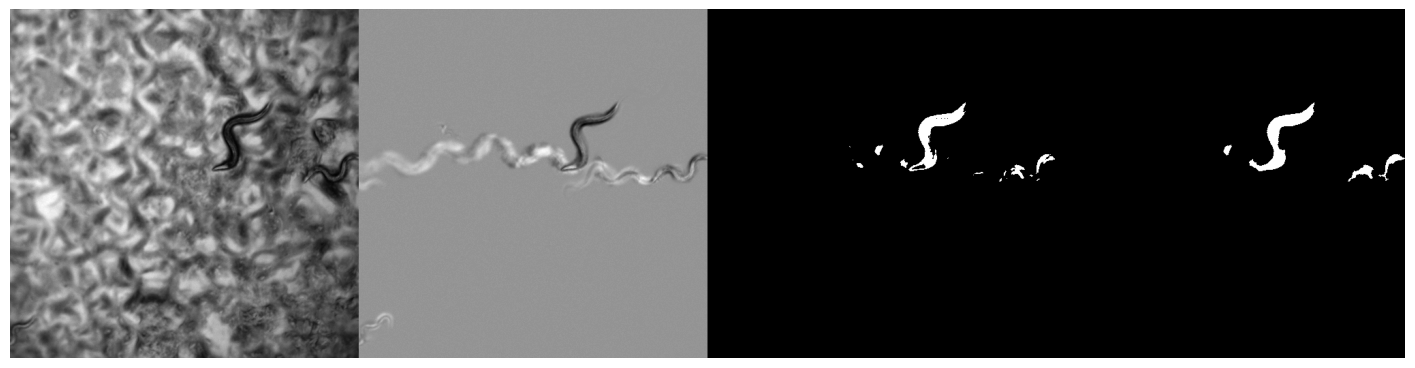

In [55]:
im = get_example("in", 1)
im_bg = subtract_background(im)

frame = im[0, :, :]
frame_bg = im_bg[0, :, :]

# Intensity thresholding on the background-subtracted image.
thresh = skimage.filters.threshold_otsu(frame_bg)
mask = frame_bg < thresh

imshow(frame, frame_bg, mask, cleanup_mask(mask), figsize=(18, 6))

### Generating a background mask *without* background subtraction

The logic of attempting to do this is that it would capture stationary worms and it would avoid the "ghosting" around mobile worms that results from the background subtraction.

In [25]:
def make_background_mask(frame, estimated_background_mask):
    """
    Create a binary mask of the background by thresholding the standard deviation of the image.
    """
    # Use a DoG filter to enhance the edges of the worms.
    # This works by supressing the blurry, low-spatial-frequency background
    # relative to the sharp, high-frequency edges of the worms.
    dog_filtered = skimage.filters.difference_of_gaussians(frame, low_sigma=0.3, high_sigma=3)

    # A built-in skimage filter to find edges seems to work the best.
    # Reference: https://scikit-image.org/docs/stable/auto_examples/edges/plot_ridge_filter.html#ridge-operators.
    edges = skimage.filters.sato(dog_filtered, sigmas=[0.3, 1], black_ridges=True)

    # Find a threshold for the edges using Otsu's method and the estimated background mask.
    thresh = skimage.filters.threshold_otsu(edges[estimated_background_mask])
    mask = edges > thresh

    return mask, dog_filtered, edges

In [26]:
im = get_example("in", 0)
_, mask_from_std_dev = make_background_mask_from_standard_deviation(im)

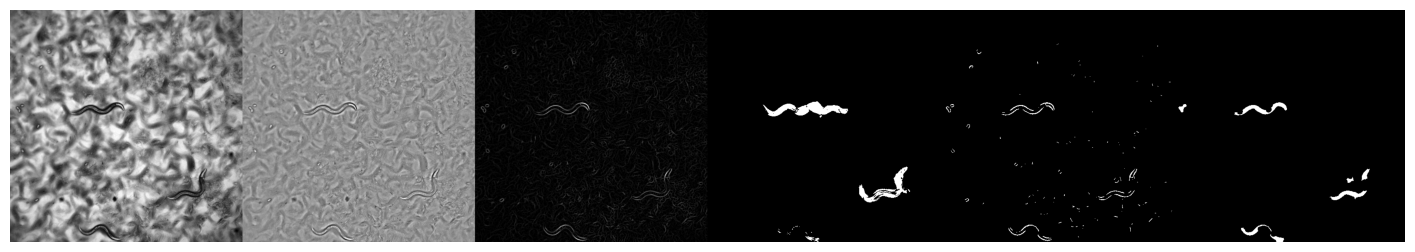

In [35]:
frame = im[99, :, :]

mask, dog_filtered, edges = make_background_mask(frame, estimated_background_mask=mask_from_std_dev)
imshow(frame, dog_filtered, edges, mask_from_std_dev, mask, cleanup_mask(mask), figsize=(18, 6))